In [1]:
#Code referenced from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 #Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size + hidden_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,category,input,hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((output,hidden),1)        
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden

    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

In [3]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line


In [4]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters-1)
    return torch.LongTensor(letter_indexes)

In [14]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [17]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output,hidden = rnn(category_tensor, input_line_tensor[i],hidden)
        l = criterion(output,target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [9]:
#keep track of training

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m,s)


In [18]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1,n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (5000 5%) 3.5547
0m 17s (10000 10%) 2.7681
0m 25s (15000 15%) 2.6346
0m 33s (20000 20%) 2.4952
0m 41s (25000 25%) 3.1117
0m 50s (30000 30%) 2.5794
0m 58s (35000 35%) 3.8058
1m 6s (40000 40%) 3.0217
1m 14s (45000 45%) 3.2739
1m 23s (50000 50%) 1.4477
1m 31s (55000 55%) 2.7136
1m 39s (60000 60%) 2.1749
1m 48s (65000 65%) 1.6021
1m 56s (70000 70%) 2.4375
2m 4s (75000 75%) 3.3516
2m 12s (80000 80%) 2.1472
2m 21s (85000 85%) 3.5175
2m 29s (90000 90%) 1.9720
2m 37s (95000 95%) 1.3692
2m 46s (100000 100%) 1.5227


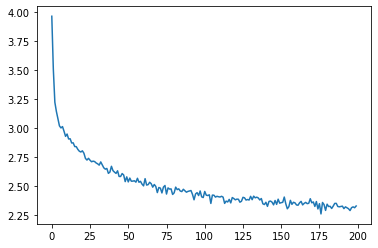

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [31]:
max_length = 20

def sample(category,start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0],hidden)
            topv,topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovellon
Uanten
Shavers
Gerring
Erengel
Romer
Salla
Parez
Allane
Cha
Hai
Iun
